In [1]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


# **Part 1: Data Preprocessing and Baseline Modeling**

In [2]:
from datasets import load_dataset

dataset = load_dataset("cardiffnlp/tweet_eval", "sentiment")
train_data = dataset["train"]
val_data = dataset["validation"]
test_data = dataset["test"]

1) Class Distribution Analysis:

C:\Users\KimoStore\AppData\Local\Temp\ipykernel_9736\2551061521.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="label", data=df, palette="viridis")


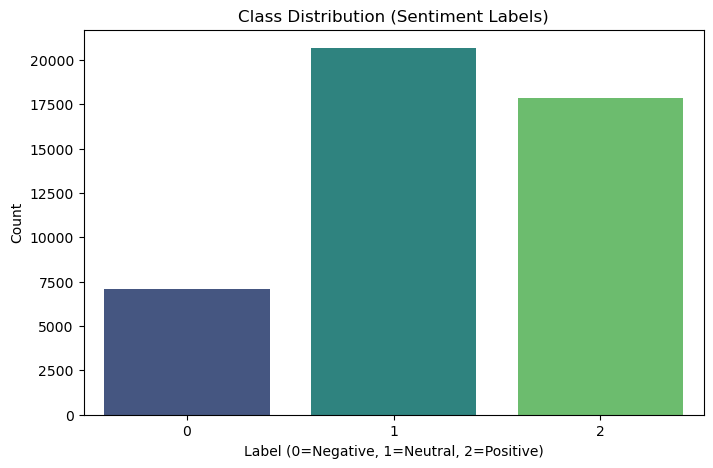

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.DataFrame(train_data)

plt.figure(figsize=(8, 5))
sns.countplot(x="label", data=df, palette="viridis")
plt.title("Class Distribution (Sentiment Labels)")
plt.xlabel("Label (0=Negative, 1=Neutral, 2=Positive)")
plt.ylabel("Count")
plt.show()

2) Tweet Length Analysis:

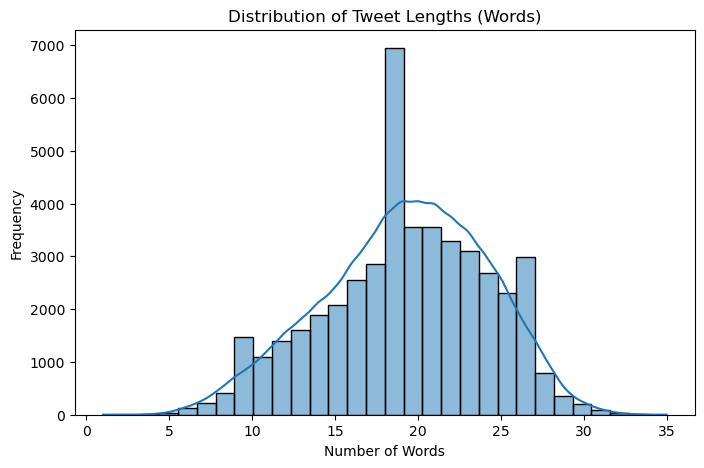

In [9]:
df["tweet_length"] = df["text"].apply(lambda x: len(x.split()))

plt.figure(figsize=(8, 5))
sns.histplot(df["tweet_length"], bins=30, kde=True)
plt.title("Distribution of Tweet Lengths (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

3) Most Frequent Words:

In [10]:
from collections import Counter
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KimoStore\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [11]:
def get_top_words(texts, n=10, sentiment=None):
    words = []
    for text in texts:
        words.extend([word.lower() for word in text.split() if word.lower() not in stop_words])
    return Counter(words).most_common(n)

def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(counts), y=list(words), palette="viridis")
    plt.title(title)
    plt.xlabel("Frequency")
    plt.show()

In [12]:
top_negative = get_top_words(df[df["label"] == 0]["text"], n=10)
top_neutral = get_top_words(df[df["label"] == 1]["text"], n=10)
top_positive = get_top_words(df[df["label"] == 2]["text"], n=10)

C:\Users\KimoStore\AppData\Local\Temp\ipykernel_9736\3078383933.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


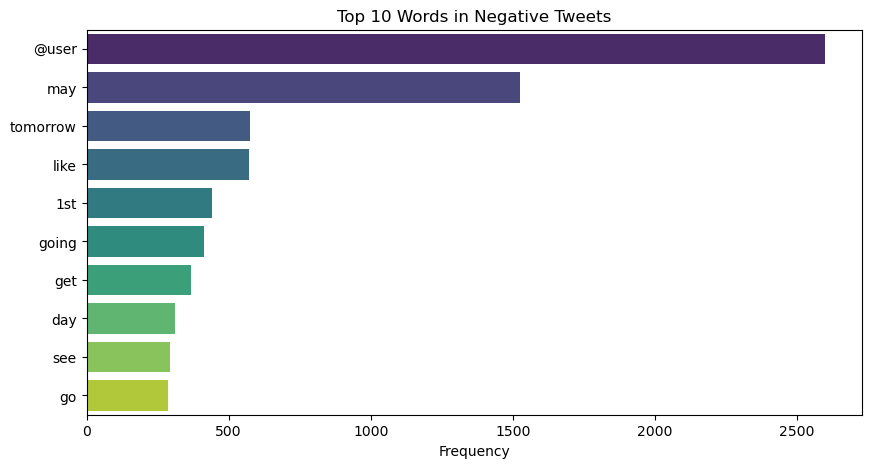

C:\Users\KimoStore\AppData\Local\Temp\ipykernel_9736\3078383933.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


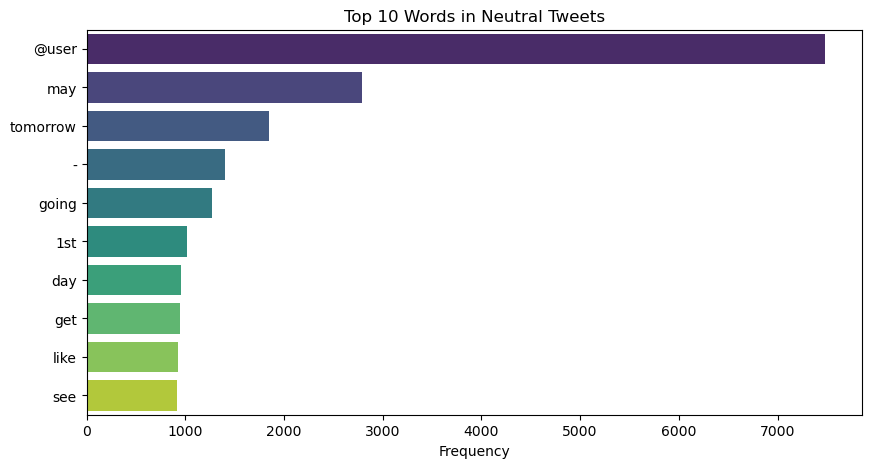

C:\Users\KimoStore\AppData\Local\Temp\ipykernel_9736\3078383933.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(words), palette="viridis")


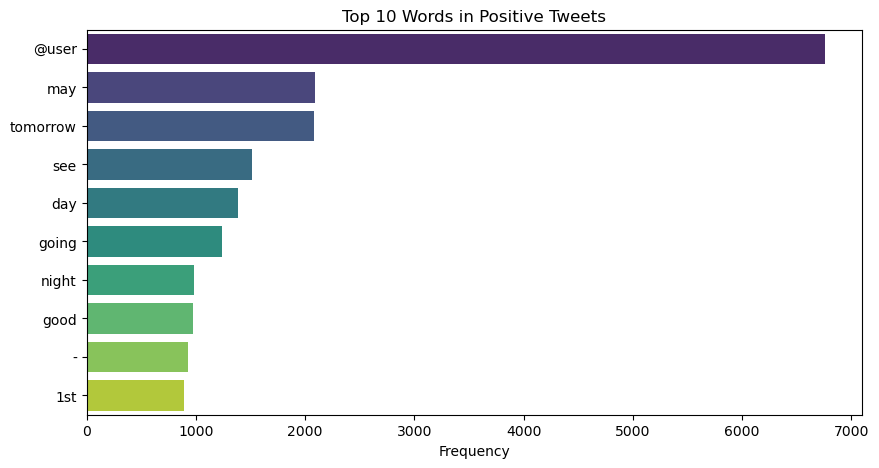

In [13]:
plot_top_words(top_negative, "Top 10 Words in Negative Tweets")
plot_top_words(top_neutral, "Top 10 Words in Neutral Tweets")
plot_top_words(top_positive, "Top 10 Words in Positive Tweets")

4) Noise Analysis:

C:\Users\KimoStore\AppData\Local\Temp\ipykernel_9736\3687796128.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(noise_stats.keys()), y=list(noise_stats.values()), palette="mako")


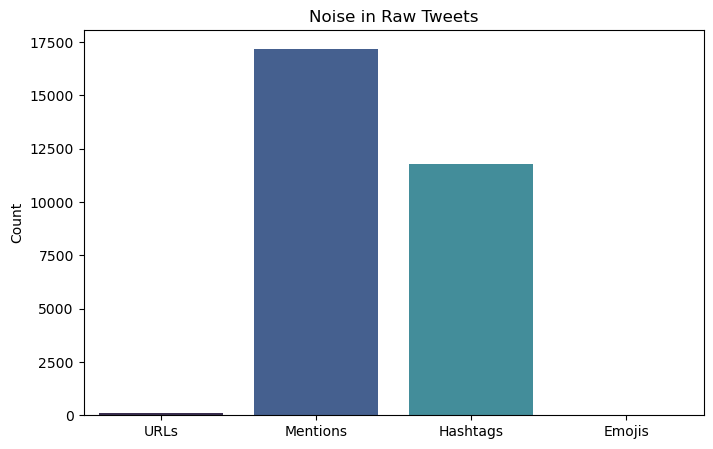

In [14]:
import re

def count_noise(texts, pattern):
    return sum(len(re.findall(pattern, text)) for text in texts)

noise_stats = {
    "URLs": count_noise(df["text"], r"http\S+|www\S+|https\S+"),
    "Mentions": count_noise(df["text"], r"@\w+"),
    "Hashtags": count_noise(df["text"], r"#\w+"),
    "Emojis": count_noise(df["text"], r"[\U0001F600-\U0001F64F]"),
}

plt.figure(figsize=(8, 5))
sns.barplot(x=list(noise_stats.keys()), y=list(noise_stats.values()), palette="mako")
plt.title("Noise in Raw Tweets")
plt.ylabel("Count")
plt.show()

# 5. Summary

In this part, we successfully:
- Preprocessed and cleaned tweets.
- Explored the dataset.
- Implemented three baseline models.

The next step is to attempt improvements to boost model performance.

## **Data Cleaning and Preprocessing**

In [15]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

nltk.download(['punkt', 'wordnet', 'stopwords', 'omw-1.4'])

def clean_text(text):
    text = text.lower()
    
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#(\w+)', r'\1', text)
    
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)  
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

sample_tweet = "RT @user: Check out this cool link! https://example.com #NLP 😊 #machinelearning"
print("Original:", sample_tweet)
print("Cleaned:", clean_text(sample_tweet))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\KimoStore\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\KimoStore\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\KimoStore\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\KimoStore\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Original: RT @user: Check out this cool link! https://example.com #NLP 😊 #machinelearning
Cleaned: rt check cool link nlp machinelearning


In [16]:
df['cleaned_text'] = df['text'].apply(clean_text)

In [17]:
def noise_analysis(df, text_column='text'):
    noise_stats = {
        'URLs': df[text_column].str.count(r'http\S+|www\S+|https\S+').sum(),
        'Mentions': df[text_column].str.count(r'@\w+').sum(),
        'Hashtags': df[text_column].str.count(r'#\w+').sum(),
        'Emojis': df[text_column].str.count(r'[\U0001F600-\U0001F64F]').sum(),
        # 'SpecialChars': df[text_column].str.count(r'[^a-zA-Z\s]').sum()
    }
    return noise_stats

C:\Users\KimoStore\AppData\Local\Temp\ipykernel_9736\850451473.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(before_stats.keys()), y=list(before_stats.values()), palette='Blues_d')
C:\Users\KimoStore\AppData\Local\Temp\ipykernel_9736\850451473.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(after_stats.keys()), y=list(after_stats.values()), palette='Greens_d')


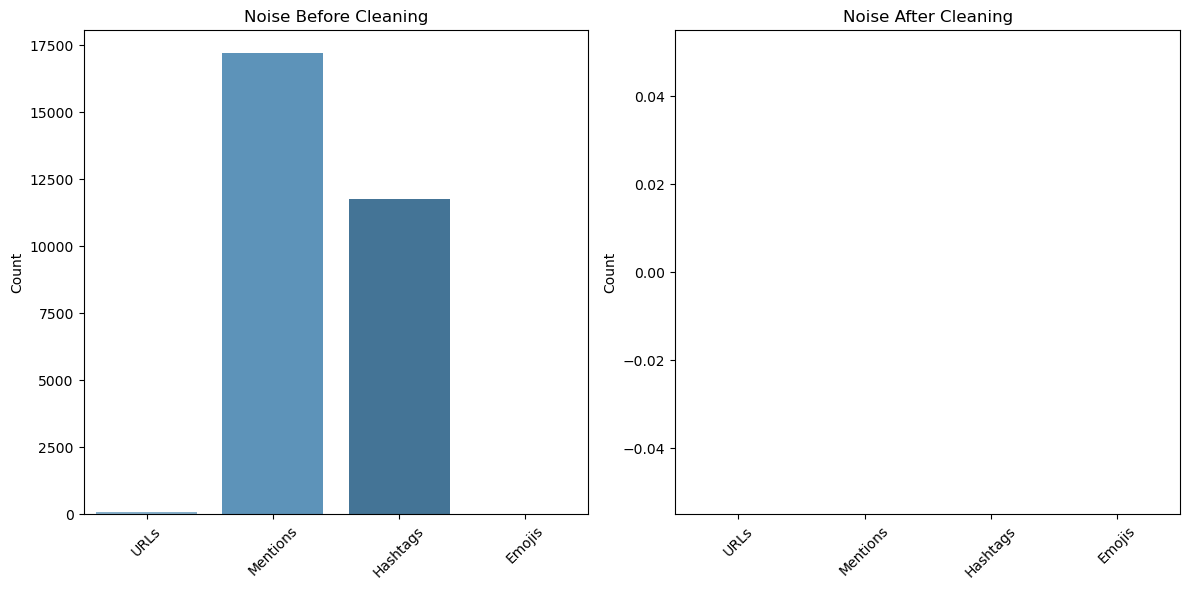

In [18]:
before_stats = noise_analysis(df, 'text')
after_stats = noise_analysis(df, 'cleaned_text')

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=list(before_stats.keys()), y=list(before_stats.values()), palette='Blues_d')
plt.title('Noise Before Cleaning')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.subplot(1, 2, 2)
sns.barplot(x=list(after_stats.keys()), y=list(after_stats.values()), palette='Greens_d')
plt.title('Noise After Cleaning')
plt.xticks(rotation=45)
plt.ylabel('Count')

plt.tight_layout()
plt.show()

# Part 1.3: Baseline Models

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch import nn
import torch.nn.functional as F

class TweetDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def collate_fn(batch):
        texts, labels = zip(*batch)
        padded_texts = pad_sequence(texts, batch_first=True)
        return padded_texts, torch.tensor(labels)

### a) Long Short-Term Memory Network (LSTM)

We build an LSTM model, a variant of RNNs designed to capture long-range dependencies and better handle vanishing gradient issues.

In [15]:
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, (hidden, _) = self.lstm(embedded)
        return self.fc(hidden[-1])

### b) Recurrent Neural Network (RNN)

We build an RNN that sequentially processes tweet tokens. RNNs capture sequential dependencies but can struggle with long-term dependencies.

In [16]:
class RNNClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        _, hidden =self.rnn(embedded)
        return self.fc(hidden[-1])

### c) Feedforward Model

In [17]:
class FeedForwardClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.fc1 = nn.Linear(embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        avg_embeds = embedded.mean(dim=1)
        x = F.relu(self.fc1(avg_embeds))
        return self.fc2(x)


# 4. Training and Evaluation

Each model is trained on the training set and evaluated on the validation set.

Metrics reported:
- Training and Validation Accuracy over epochs
- Confusion Matrix
- F1-Score and Accuracy

These metrics help us measure model performance and guide improvements.

In [6]:
from tqdm import tqdm

def train(model, dataloader, optimizer, criterion, device='cpu'):
    model.train()
    running_loss = 0
    progress_bar = tqdm(dataloader, desc="Training", leave=False)
    
    for inputs, targets in progress_bar:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
    
    return running_loss / len(dataloader)

def evaluate(model, dataloader, criterion, device='cpu'):
    model.eval()
    correct, total, total_loss = 0, 0, 0
    progress_bar = tqdm(dataloader, desc="Evaluating", leave=False)
    
    with torch.no_grad():
        for inputs, targets in progress_bar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item()
            preds = outputs.argmax(dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    
    accuracy = correct / total
    avg_loss = total_loss / len(dataloader)
    return accuracy, avg_loss


#### Evaluation Metrics

In [7]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_all_preds(model, dataloader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
    return all_labels, all_preds

In [20]:
from collections import Counter

tokenized_texts = [text.split() for text in df["cleaned_text"]]

all_tokens = [token for text in tokenized_texts for token in text]
token_counts = Counter(all_tokens)
vocab = {"<pad>": 0, "<unk>": 1}
vocab.update({word: i+2 for i, (word, _) in enumerate(token_counts.items())})

inv_vocab = {idx: token for token, idx in vocab.items()}

X = [torch.tensor([vocab.get(token, vocab["<unk>"]) for token in text]) for text in tokenized_texts]
y = torch.tensor(df["label"].values)


In [23]:
dataset = TweetDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=TweetDataset.collate_fn)


### 1) Training of LSTM Model

In [22]:
lstm_model = LSTMClassifier(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=3,
    pad_idx=vocab["<pad>"]
)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    train_loss = train(lstm_model, dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")


Epoch 1, Loss: 0.9269


Epoch 2, Loss: 0.7787


Epoch 3, Loss: 0.6620


Epoch 4, Loss: 0.5498


Epoch 5, Loss: 0.4371


Epoch 6, Loss: 0.3336


Epoch 7, Loss: 0.2519


Epoch 8, Loss: 0.1900


Epoch 9, Loss: 0.1437


Epoch 10, Loss: 0.1138


### 2) Training of RNN Model

In [24]:
vanilla_rnn_model = RNNClassifier(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=3,
    pad_idx=vocab["<pad>"]
)

optimizer = torch.optim.Adam(vanilla_rnn_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    train_loss = train(vanilla_rnn_model, dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")


Epoch 1, Loss: 1.0185


Epoch 2, Loss: 1.0163


Epoch 3, Loss: 0.9776


Epoch 4, Loss: 0.9167


Epoch 5, Loss: 0.8562


Epoch 6, Loss: 0.7906


Epoch 7, Loss: 0.7410


Epoch 8, Loss: 0.6948


Epoch 9, Loss: 0.6540


Epoch 10, Loss: 0.6152


### 3) Training of FFN Model

In [26]:
ff_model = FeedForwardClassifier(
    vocab_size=len(vocab),
    embedding_dim=100,
    hidden_dim=128,
    output_dim=3,
    pad_idx=vocab["<pad>"]
)

optimizer = torch.optim.Adam(ff_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    train_loss = train(ff_model, dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")


Epoch 1, Loss: 0.9072


Epoch 2, Loss: 0.7507


Epoch 3, Loss: 0.6511


Epoch 4, Loss: 0.5690


Epoch 5, Loss: 0.4973


Epoch 6, Loss: 0.4325


Epoch 7, Loss: 0.3747


Epoch 8, Loss: 0.3225


Epoch 9, Loss: 0.2768


Epoch 10, Loss: 0.2357


### Evaluation of the Models

In [60]:

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def get_all_preds(model, dataloader, device='cpu'):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

def evaluate_model(model, dataloader, name="Model"):
    true_labels, predictions = get_all_preds(model, dataloader, device)
    print(f"\nClassification Report for {name}:")
    print(classification_report(true_labels, predictions, target_names=["Negative", "Neutral", "Positive"], digits=5))
    cm = confusion_matrix(true_labels, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Neutral", "Positive"],
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix - {name}")
    plt.show()



Classification Report for FeedForward:
              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94      7093
     Neutral       0.94      0.94      0.94     20673
    Positive       0.94      0.94      0.94     17849

    accuracy                           0.94     45615
   macro avg       0.94      0.94      0.94     45615
weighted avg       0.94      0.94      0.94     45615



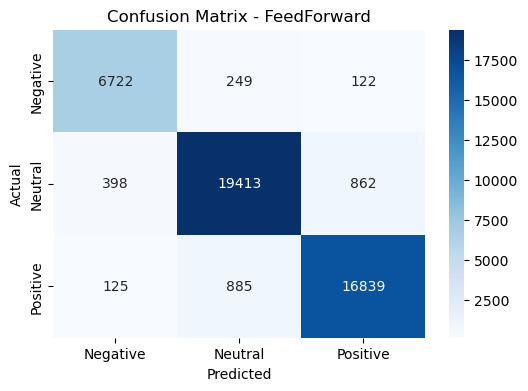


Classification Report for LSTM:
              precision    recall  f1-score   support

    Negative       0.96      0.96      0.96      7093
     Neutral       0.97      0.98      0.98     20673
    Positive       0.99      0.97      0.98     17849

    accuracy                           0.97     45615
   macro avg       0.97      0.97      0.97     45615
weighted avg       0.97      0.97      0.97     45615



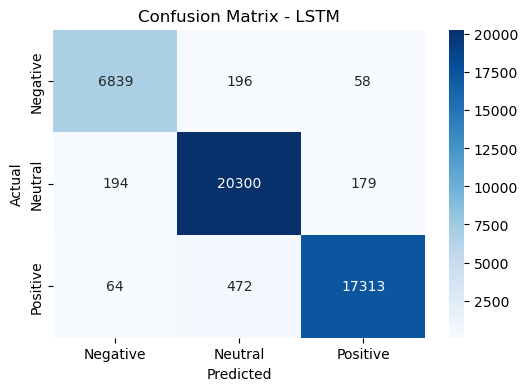


Classification Report for RNN:
              precision    recall  f1-score   support

    Negative       0.80      0.55      0.65      7093
     Neutral       0.77      0.81      0.79     20673
    Positive       0.82      0.87      0.84     17849

    accuracy                           0.79     45615
   macro avg       0.80      0.74      0.76     45615
weighted avg       0.79      0.79      0.79     45615



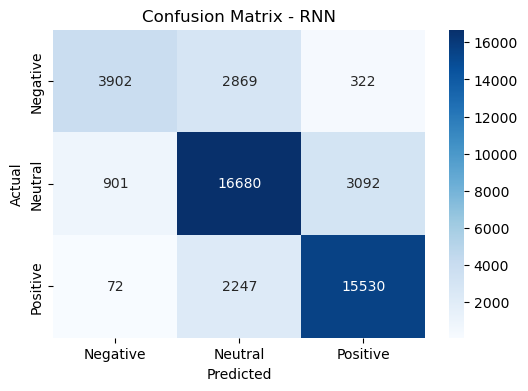

In [35]:

models = {
    "FeedForward": ff_model,
    "LSTM":lstm_model,
    "RNN": vanilla_rnn_model,
}

for name, model in models.items():
    evaluate_model(model, dataloader, name)


## Sample Testing:

Here we provided sample tweets that we randomly made to test the 3 previously implemented models and compare their results

In [34]:

from prettytable import PrettyTable

def predict_sample_texts(model, texts, vocab, device):
    model.eval()
    tokenized = [[vocab.get(token, vocab["<unk>"]) for token in text.split()] for text in texts]
    inputs = [torch.tensor(x) for x in tokenized]
    dataset = TweetDataset(inputs, [0]*len(inputs))  
    dataloader = DataLoader(dataset, batch_size=1, collate_fn=TweetDataset.collate_fn)
    preds = []
    with torch.no_grad():
        for x, _ in dataloader:
            x = x.to(device)
            output = model(x)
            pred = torch.argmax(output, dim=1).item()
            preds.append(pred)
    return preds

sample_texts = [
    "I love this product!",
    "This is the worst experience I've ever had.",
    "It was okay, nothing special.",
    "Absolutely fantastic!",
    "I wouldn’t recommend it to anyone.",
    "Meh, I’ve seen better.",
    "look at https://www.ladygaga.com/us-en/, she is having a splendid merch!!"
]

label_map = {0: "Negative", 1: "Neutral", 2: "Positive"}
table = PrettyTable(["Sample Text", "True Label", "FeedForward", "LSTM", "RNN"])

true_labels = [2, 0, 1, 2, 0, 1, 2]  

feed_preds = predict_sample_texts(models["FeedForward"], sample_texts, vocab, device)
lstm_preds = predict_sample_texts(models["LSTM"], sample_texts, vocab, device)
rnn_preds = predict_sample_texts(models["RNN"], sample_texts, vocab, device)

for text, true, f, l, r in zip(sample_texts, true_labels, feed_preds, lstm_preds, rnn_preds):
    table.add_row([text, label_map[true], label_map[f], label_map[l], label_map[r]])

print(table)


+---------------------------------------------------------------------------+------------+-------------+----------+----------+
|                                Sample Text                                | True Label | FeedForward |   LSTM   |   RNN    |
+---------------------------------------------------------------------------+------------+-------------+----------+----------+
|                            I love this product!                           |  Positive  |   Positive  | Positive | Positive |
|                This is the worst experience I've ever had.                |  Negative  |   Negative  | Positive | Negative |
|                       It was okay, nothing special.                       |  Neutral   |   Positive  | Positive | Neutral  |
|                           Absolutely fantastic!                           |  Positive  |   Neutral   | Positive | Neutral  |
|                     I wouldn’t recommend it to anyone.                    |  Negative  |   Positive  | Positi

# **Part 2: Improving the Performance**

### Trial 1: Model Restructing (Stacked LSTM + Increased Hidden Size + Dropout)

In [4]:
import torch.nn as nn

class StackedLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(StackedLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return output

In [5]:
embedding_dim = 100
hidden_dim = 256
output_dim = 3  
num_layers = 2
dropout = 0.5

In [52]:
stackedLSTM_model = StackedLSTMModel(vocab_size=len(vocab), embedding_dim=embedding_dim, 
                         hidden_dim=hidden_dim, output_dim=output_dim,
                         num_layers=num_layers, dropout=dropout)

stackedLSTM_model = stackedLSTM_model.to(device)

optimizer = torch.optim.Adam(stackedLSTM_model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

for epoch in range(10):
    train_loss = train(stackedLSTM_model, dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

Training:   0%|          | 0/1426 [00:00<?, ?it/s]

Epoch 1, Loss: 0.9669


Epoch 2, Loss: 0.8044


Epoch 3, Loss: 0.6873


Epoch 4, Loss: 0.5776


Epoch 5, Loss: 0.4612


Epoch 6, Loss: 0.3510


Epoch 7, Loss: 0.2615


Epoch 8, Loss: 0.1987


Epoch 9, Loss: 0.1539


Epoch 10, Loss: 0.1238


### Trial 2: Model Restructing (LSTM + Word2Vec + Dropout) 

In [29]:
import gensim.downloader as api

word2vec_model = api.load('word2vec-google-news-300') 

embedding_dim = 300  # Because Word2Vec Google News vectors are 300-dimensional
embedding_matrix = torch.randn(len(vocab), embedding_dim) 

for word, idx in vocab.items():
    if word in word2vec_model:
        embedding_matrix[idx] = torch.tensor(word2vec_model[word])

[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [30]:
class Word2VecLSTMModel(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers, dropout):
        super(Word2VecLSTMModel, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        output = self.fc(hidden[-1])
        return output

In [31]:
hidden_dim = 256
output_dim = 3
num_layers = 1
dropout = 0.3

In [32]:
word2vecLSTM_model = Word2VecLSTMModel(embedding_matrix, hidden_dim, output_dim, num_layers, dropout)

d:\Apps files\anaconda3\Lib\site-packages\torch\nn\modules\rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [35]:
word2vecLSTM_model = word2vecLSTM_model.to(device)
optimizer = torch.optim.Adam(word2vecLSTM_model.parameters(), lr=1e-3)

for epoch in range(10):
    train_loss = train(word2vecLSTM_model, dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

Epoch 1, Loss: 0.9674


Epoch 2, Loss: 0.7816


Epoch 3, Loss: 0.7132


Epoch 4, Loss: 0.6448


Epoch 5, Loss: 0.5692


Epoch 6, Loss: 0.4958


Epoch 7, Loss: 0.4207


Epoch 8, Loss: 0.3444


Epoch 9, Loss: 0.2706


Epoch 10, Loss: 0.2043


### Trial 3: Model Restructing (BiLSTM + Dropout)

In [37]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, 
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # hidden_dim * 2 because bidirectional
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        # Concatenate the final forward and backward hidden states
        hidden_forward = hidden[-2,:,:]
        hidden_backward = hidden[-1,:,:]
        hidden_concat = torch.cat((hidden_forward, hidden_backward), dim=1)
        output = self.fc(hidden_concat)
        return output


In [49]:
embedding_dim = 100
hidden_dim = 128
output_dim = 3
num_layers = 2
dropout = 0.5

In [50]:
BiLSTM_model = BiLSTMModel(vocab_size=len(vocab), embedding_dim=embedding_dim,
                    hidden_dim=hidden_dim, output_dim=output_dim,
                    num_layers=num_layers, dropout=dropout)

BiLSTM_model = BiLSTM_model.to(device)

optimizer = torch.optim.Adam(BiLSTM_model.parameters(), lr=1e-3)

for epoch in range(20):
    train_loss = train(BiLSTM_model, dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

Training:   0%|          | 0/1426 [00:00<?, ?it/s]

Epoch 1, Loss: 0.8986


Epoch 2, Loss: 0.7421


Epoch 3, Loss: 0.6236


Epoch 4, Loss: 0.5021


Epoch 5, Loss: 0.3820


Epoch 6, Loss: 0.2782


Epoch 7, Loss: 0.2006


Epoch 8, Loss: 0.1519


Epoch 9, Loss: 0.1141


Epoch 10, Loss: 0.0917


Epoch 11, Loss: 0.0737


Epoch 12, Loss: 0.0646


Epoch 13, Loss: 0.0531


Epoch 14, Loss: 0.0518


Epoch 15, Loss: 0.0419


Epoch 16, Loss: 0.0388


Epoch 17, Loss: 0.0380


Epoch 18, Loss: 0.0360


Epoch 19, Loss: 0.0308


Epoch 20, Loss: 0.0289


### Trial 4: Model Restructing (BiLSTM + GLoVe embeddings + Dropout)

In [44]:
import numpy as np
glove_path = 'glove.6B.100d.txt' 

glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector

print(f"Loaded {len(glove_embeddings)} word vectors from GloVe.")

embedding_dim = 100
embedding_matrix = torch.randn(len(vocab), embedding_dim) 

for word, idx in vocab.items():
    if word in glove_embeddings:
        embedding_matrix[idx] = torch.tensor(glove_embeddings[word])

Loaded 400000 word vectors from GloVe.


In [45]:
class BiLSTMWithGloVe(nn.Module):
    def __init__(self, embedding_matrix, hidden_dim, output_dim, num_layers, dropout):
        super(BiLSTMWithGloVe, self).__init__()
        num_embeddings, embedding_dim = embedding_matrix.shape
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_matrix)
        self.embedding.weight.requires_grad = False  # Freeze embeddings
        
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (hidden, cell) = self.lstm(embedded)
        hidden_forward = hidden[-2,:,:]
        hidden_backward = hidden[-1,:,:]
        hidden_concat = torch.cat((hidden_forward, hidden_backward), dim=1)
        output = self.fc(hidden_concat)
        return output

In [47]:
BiLSTMGlove_model = BiLSTMWithGloVe(embedding_matrix, hidden_dim, output_dim, num_layers, dropout)

BiLSTMGlove_model = BiLSTMGlove_model.to(device)

optimizer = torch.optim.Adam(BiLSTMGlove_model.parameters(), lr=1e-3)

for epoch in range(20):
    train_loss = train(BiLSTMGlove_model, dataloader, optimizer, criterion)
    print(f"Epoch {epoch+1}, Loss: {train_loss:.4f}")

Training:   0%|          | 0/1426 [00:00<?, ?it/s]

Epoch 1, Loss: 0.8497


Epoch 2, Loss: 0.7766


Epoch 3, Loss: 0.7393


Epoch 4, Loss: 0.6999


Epoch 5, Loss: 0.6543


Epoch 6, Loss: 0.6033


Epoch 7, Loss: 0.5472


Epoch 8, Loss: 0.4884


Epoch 9, Loss: 0.4282


Epoch 10, Loss: 0.3727


Epoch 11, Loss: 0.3232


Epoch 12, Loss: 0.2780


Epoch 13, Loss: 0.2400


Epoch 14, Loss: 0.2091


Epoch 15, Loss: 0.1815


Epoch 16, Loss: 0.1658


Epoch 17, Loss: 0.1436


Epoch 18, Loss: 0.1334


Epoch 19, Loss: 0.1200


Epoch 20, Loss: 0.1044


### Evaluation of the trials


Classification Report for StackedLSTM:
              precision    recall  f1-score   support

    Negative    0.97715   0.96475   0.97091      7093
     Neutral    0.96699   0.98491   0.97587     20673
    Positive    0.98667   0.97047   0.97851     17849

    accuracy                        0.97613     45615
   macro avg    0.97694   0.97338   0.97510     45615
weighted avg    0.97627   0.97613   0.97613     45615



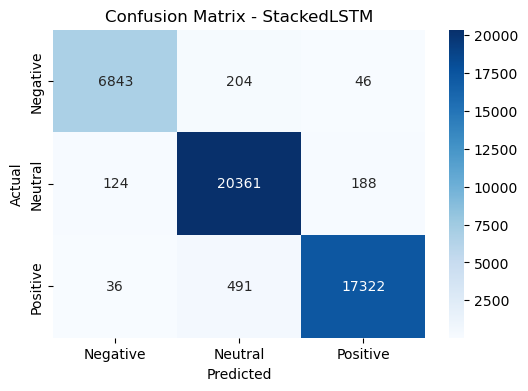


Classification Report for Word2VecLSTM:
              precision    recall  f1-score   support

    Negative    0.92199   0.95813   0.93971      7093
     Neutral    0.95500   0.95772   0.95636     20673
    Positive    0.97276   0.95440   0.96349     17849

    accuracy                        0.95648     45615
   macro avg    0.94992   0.95675   0.95319     45615
weighted avg    0.95682   0.95648   0.95656     45615



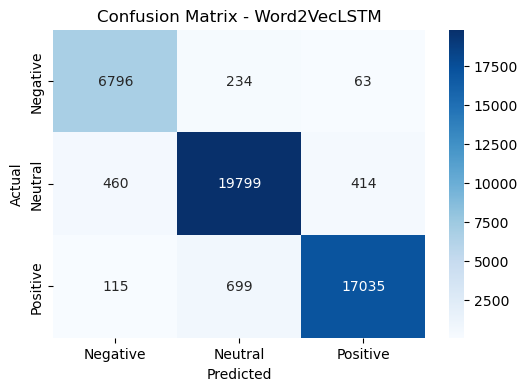


Classification Report for BiLSTM:
              precision    recall  f1-score   support

    Negative    0.99522   0.99732   0.99627      7093
     Neutral    0.99661   0.99555   0.99608     20673
    Positive    0.99642   0.99681   0.99661     17849

    accuracy                        0.99632     45615
   macro avg    0.99608   0.99656   0.99632     45615
weighted avg    0.99632   0.99632   0.99632     45615



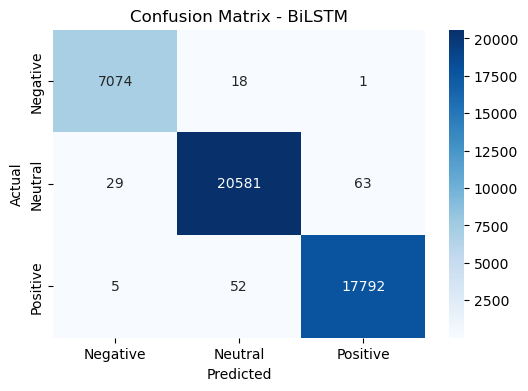


Classification Report for GloveBiLSTM:
              precision    recall  f1-score   support

    Negative    0.98771   0.97476   0.98120      7093
     Neutral    0.98315   0.98800   0.98557     20673
    Positive    0.98750   0.98700   0.98725     17849

    accuracy                        0.98555     45615
   macro avg    0.98612   0.98326   0.98467     45615
weighted avg    0.98556   0.98555   0.98555     45615



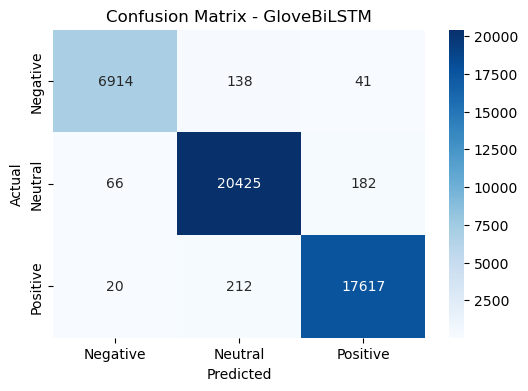

In [61]:
models = {
    "StackedLSTM": stackedLSTM_model,
    "Word2VecLSTM":word2vecLSTM_model,
    "BiLSTM": BiLSTM_model, 
    "GloveBiLSTM": BiLSTMGlove_model,
}

for name, model in models.items():
    evaluate_model(model, dataloader, name)